This Jupyter Notebook plots and analyzes ligand-detected 1H nuclear magnetic resonance spectroscopy (NMR) data of 5-fluoroindole in the absence and presence of varying concentrations of the non-structural protein 5A, domains 2 and 3 (NS5A-D2D3). Data should first be downloaded from Zenodo as detailed in ../README.md. Data are in .ft2 format. Filenames indicate protein concentration (e.g. '28_7uM.ft2' indicates 28.7uM NS5A-D2D3). The concentration of 5-fluoroindole was held constant at 50 uM in all experiments.

In [1]:
# Import useful stuff
%matplotlib inline
import os, sys
import nmrglue as ng
import numpy as np
import glob
import json
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from fit_raw import * # the included fit_raw.py file contains some useful functions
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots


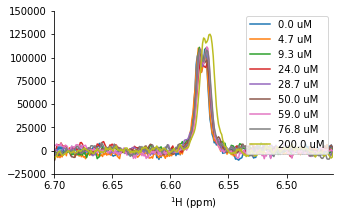

In [2]:
# Plot various 1D 19F NMR curves

# Create an instance of the fit_raw class
fit_1D_1H = fit_raw()

# Read and process the data
dic, data = fit_1D_1H.read_data('../Data/1H_1D_ft2_data/')

# Create a dictionary to group data by concentration
group_dict = {}
for key in data.keys():
    prefix = key.split('_')[1:3]
    prefix_dec = prefix[1].split('uM')
    join = prefix[0] + "." + "".join(prefix_dec)
    if join.startswith('d'):
        continue
    if join not in group_dict:
        group_dict[join] = []
    group_dict[join].append(key)

# Sort the dictionary keys by concentration
sorted_keys = sorted(group_dict.keys(), key=lambda x: float(x.split('uM')[0]))

# Create the plot
fig, ax = plt.subplots(figsize=(5,3))

# Loop over grouped data, calculate average and standard error, and plot
for prefix in sorted_keys:
    keys = group_dict[prefix]
    # Collect the data and calculate average and standard error
    spectra = []
    for key in keys:
        spectra.append(data[key])
    avg_spectrum = np.mean(spectra, axis=0)
    ste_spectrum = np.std(spectra, axis=0) / np.sqrt(len(spectra))

    # Get the x-axis values (ppm_real)
    udic = ng.pipe.guess_udic(dic[keys[0]], data[keys[0]])
    ppm_real = ng.fileiobase.unit_conversion(udic[0]['size'],True,udic[0]['sw'],udic[0]['obs'],udic[0]['car']).ppm_scale() 

    # Plot the average spectrum with standard error
    ax.plot(ppm_real, avg_spectrum, label=prefix + " uM")
    ax.fill_between(ppm_real, avg_spectrum-ste_spectrum, avg_spectrum+ste_spectrum, alpha=0.7)

# Add axis labels and format plot
plt.xlabel('Frequency (Hz)')
ax.axes.get_yaxis().set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.set_xlabel("$^{1}$H (ppm)")
ax.set_xlim(6.7, 6.46)
ax.set_ylim(-.0025*10**(7),0.015*10**(7))
ax.legend()

# Show the plot
plt.show()


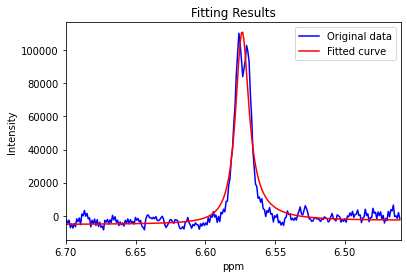

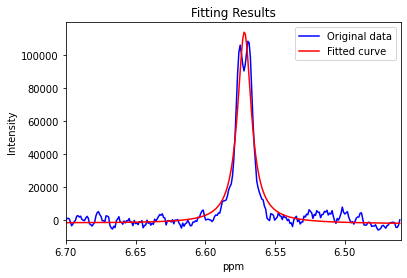

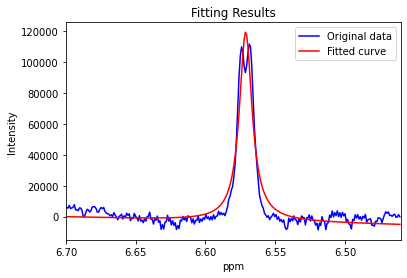

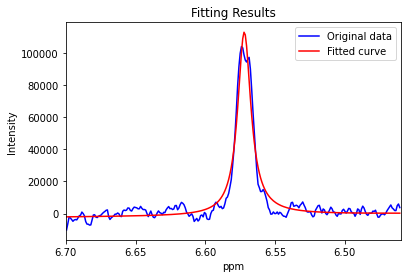

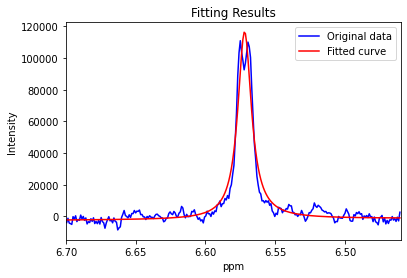

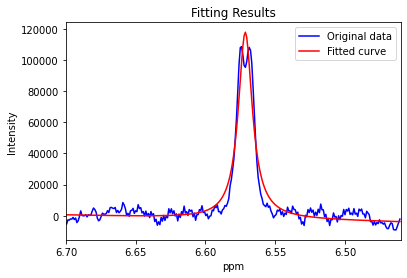

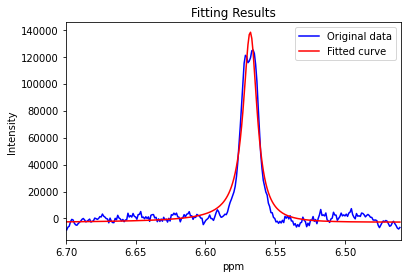

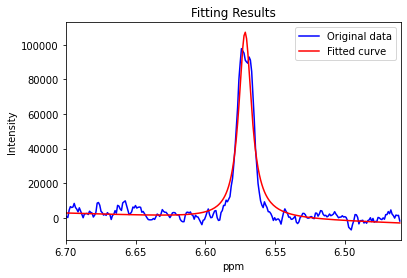

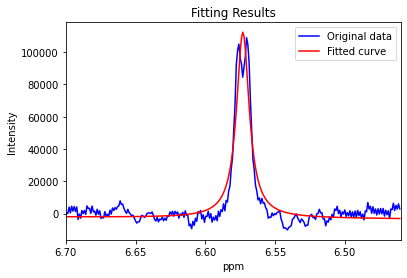

In [3]:
# Fit the locations of 1H chemical shifts

# Create a dictionary to store values by concentration
concs_f0s_av = {}
concs_f0s_se = {}

# Loop over grouped data, calculate average and standard error, then plot
for key in group_dict:
    f0_vals = [] # Average values
    f0_errs = [] # Standard errors
    for i in group_dict[key]:
        popt, perr, fit_curve = fit_1D_1H.fit_1D(dic=dic[i], data=data[i])
        f0_vals.append(popt[0])
        f0_errs.append(perr[0])
    concs_f0s_av[key] = np.asarray(f0_vals)[0]
    concs_f0s_se[key] = np.asarray(f0_errs)[0]


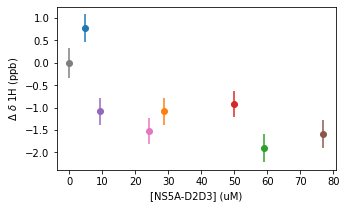

In [4]:
# Plot chemical shift perturbation as a function of NS5A-D2D3 concentration
fig, ax = plt.subplots(figsize=(5,3))
for key in concs_f0s_av:
    if np.float(key) != 200.0: # Uncomment this to include high concentration point
        ax.scatter(np.float(key), 10**3*(concs_f0s_av[key]-concs_f0s_av['0.0']))
        ax.errorbar(np.float(key), 10**3*(concs_f0s_av[key]-concs_f0s_av['0.0']), yerr=10**3*np.sqrt(concs_f0s_se[key]**2+concs_f0s_se['0.0']**2))
        ax.set_xlabel('[NS5A-D2D3] (uM)')
        ax.set_ylabel('$\Delta$ $\delta$ 1H (ppb)')
ax.ticklabel_format(useOffset=False)
plt.show()

In [5]:
# Save the dictionaries to JSON files
# Saved in the current directory as not used in tau_c analysis
with open('concs_f0s_av.json', 'w') as outfile:
    json.dump(concs_f0s_av, outfile)
    
with open('concs_f0s_se.json', 'w') as outfile:
    json.dump(concs_f0s_se, outfile)